<a href="https://colab.research.google.com/github/SheikhMudassarHanif/NLP/blob/main/LanguageTranslationRNN%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [4]:
import nltk
nltk.download('punkt')
import LughaatNLP

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from LughaatNLP import LughaatNLP
urdu_text_processing = LughaatNLP()


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [6]:
columns=pd.read_excel('/content/parallel-corpus.xlsx',nrows=0).columns.tolist()
df=pd.read_excel('/content/parallel-corpus.xlsx',usecols=[columns[0],columns[1]])
df.head()
df.describe()

,SENTENCES,MEANING
count,30120,29618
unique,23662,22595
top,Good,اچھی
freq,265,285


#The file iam importing has been cleaned . (Contains stopwords) and its lemmatized to reduce vocabulory size

In [2]:
columns=pd.read_csv('/content/fulldatafullcleaned.csv',nrows=0).columns.tolist()
df=pd.read_csv('/content/fulldatafullcleaned.csv',usecols=[columns[1],columns[2]])
df.describe()
sentences_count_with_nan=len(df)
df.dropna(inplace=True)
sentences_count_without_nan=len(df)
print('Before Nan ',sentences_count_with_nan)
print('After Nan ',sentences_count_without_nan)

df.head()
df.describe()



Before Nan  29617
After Nan  29574


,SENTENCES,MEANING
count,29574,29574
unique,21650,22116
top,good,اچھی
freq,290,290


In [3]:

df = df.drop_duplicates()
df.describe()

,SENTENCES,MEANING
count,22987,22987
unique,21650,22116
top,dont come here,(گوگل کے ذریعہ ترجمہ شدہ) (اصل)
freq,8,35


In [4]:
#90 sentences are being covered
threshold = 30
# Count sentences exceeding the threshold
count_exceeding = df[df['SENTENCES '].str.split().str.len() > threshold].shape[0]
print(count_exceeding,len(df))

2501 22987


In [5]:
df = df[df['SENTENCES '].str.split().str.len() <= threshold]


In [6]:
df.describe()

,SENTENCES,MEANING
count,20486,20486
unique,19170,19617
top,dont come here,(گوگل کے ذریعہ ترجمہ شدہ) (اصل)
freq,8,35


In [7]:
threshold = 30
# Count sentences exceeding the threshold
count_exceeding = df[df['MEANING'].str.split().str.len() > threshold].shape[0]
print(count_exceeding,len(df))

975 20486


In [8]:
df = df[df['MEANING'].str.split().str.len() <= threshold]


In [9]:


df.describe()

,SENTENCES,MEANING
count,19511,19511
unique,18222,18642
top,dont come here,(گوگل کے ذریعہ ترجمہ شدہ) (اصل)
freq,8,35


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


#useing the tokeinzer on english texts
eng_tokenizer=Tokenizer()
eng_tokenizer.fit_on_texts(df['SENTENCES '])
eng_vocab_size=len(eng_tokenizer.word_index)+1
print('English Vocabulary Size: %d' % eng_vocab_size)
eng_tokenizer.texts_to_sequences(df['SENTENCES '])
padded_eng_sentences=pad_sequences(eng_tokenizer.texts_to_sequences(df['SENTENCES ']),padding='post')


urd_tokenizer=Tokenizer()
urd_tokenizer.fit_on_texts(df['MEANING'])
urd_vocab_size=len(urd_tokenizer.word_index)+1


print('Urdu Vocabulary Size: %d' % urd_vocab_size)
encoded_urdu_sentences=urd_tokenizer.texts_to_sequences(df['MEANING'])
padded_urdu_sentences=pad_sequences(encoded_urdu_sentences,padding='post')

X=padded_eng_sentences
y=padded_urdu_sentences

# Split the dataset into train and test sets (80% train, 20% test)
# X_train, X_val, y_train, y_val = train_test_split(padded_eng_sentences, padded_urdu_sentences, test_size=0.1, random_state=42)

X_train, X_temp, y_train, y_temp = train_test_split(padded_eng_sentences, padded_urdu_sentences, test_size=0.2, random_state=42)

# Now, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# 4. Shifting Target Data
# y_train_shifted = y_train[:, 1:]  # Shift target sequences
# y_val_shifted = y_val[:, 1:]  # Shift target sequences



English Vocabulary Size: 11218
Urdu Vocabulary Size: 11099


#Using the approch of Stacked-Bidirectional LSTM

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# vocab_size=eng_vocab_size+urd_vocab_size
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad your input sequences if they are not already of the same length
max_input_length = 31  # or 30 based on your target
X_train_padded = pad_sequences(X_train, maxlen=max_input_length, padding='post')
X_val_padded = pad_sequences(X_val, maxlen=max_input_length, padding='post')

# If you pad inputs, adjust your target shapes accordingly:
y_train_padded = pad_sequences(y_train, maxlen=max_input_length, padding='post')
y_val_padded = pad_sequences(y_val, maxlen=max_input_length, padding='post')

# Fit the model with the padded sequences
# history = model.fit(X_train_padded, y_train_padded, epochs=10, batch_size=32, validation_data=(X_val_padded, y_val_padded), callbacks=callbacks)


model1=tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=eng_vocab_size,output_dim=256,input_length=30),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.TimeDistributed(Dense(urd_vocab_size,activation='softmax')) # Added TimeDistributed layer



])




# callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)]
model1.compile(optimizer=Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model1.summary()
history1 = model1.fit(X_train_padded, y_train_padded, epochs=12, batch_size=16, validation_data=(X_val_padded, y_val_padded))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
976/976 ━━━━━━━━━━━━━━━━━━━━ 70s 58ms/step - accuracy: 0.6546 - loss: 2.8873 - val_accuracy: 0.6684 - val_loss: 2.2746
Epoch 2/12
976/976 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.6717 - loss: 2.2198 - val_accuracy: 0.6799 - val_loss: 2.1456
Epoch 3/12
976/976 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.6815 - loss: 2.0752 - val_accuracy: 0.6852 - val_loss: 2.0754
Epoch 4/12
976/976 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.6888 - loss: 1.9754 - val_accuracy: 0.6916 - val_loss: 2.0195
Epoch 5/12
976/976 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.6989 - loss: 1.8612 - val_accuracy: 0.6972 - val_loss: 1.9708
Epoch 6/12
976/976 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.7078 - loss: 1.7456 - val_accuracy: 0.7014 - val_loss: 1.9334
Epoch 7/12
976/976 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.7133 - loss: 1.6623 - val_accuracy: 0.7037 - val_loss: 1.9121
Epoch 8/12
976/976 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.7196 - loss: 1.5639 - 

In [20]:
sentence='iam going to '
eng_tokenizer.texts_to_sequences([sentence])
pad_eng_sentence=pad_sequences(eng_tokenizer.texts_to_sequences([sentence]),maxlen=30,padding='post')
predictions=model1.predict(pad_eng_sentence)
predicted_seq=np.argmax(predictions,axis=-1)
# predicted_seq
# Create a reverse mapping from index to word for Urdu
urd_index_word = {v: k for k, v in urd_tokenizer.word_index.items()}

# Convert predicted sequences to words
predicted_urdu_translation = []
for word_index in predicted_seq[0]:  # Assuming a single input sentence
    if word_index != 0:  # Skip padding
        predicted_urdu_translation.append(urd_index_word.get(word_index, ''))

# Join the predicted words to form the translated sentence
translated_sentence = ' '.join(predicted_urdu_translation)
print("Predicted Urdu Translation:", translated_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Urdu Translation: ناراض


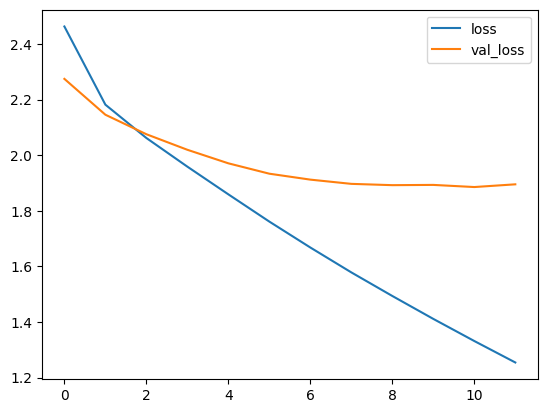

In [21]:
plt.plot(history1.history['loss'],label='loss')
plt.plot(history1.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

#ANother model with different architure

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_input_length = 31  # or 30 based on your target
X_train_padded = pad_sequences(X_train, maxlen=max_input_length, padding='post')
X_val_padded = pad_sequences(X_val, maxlen=max_input_length, padding='post')
y_train_padded = pad_sequences(y_train, maxlen=max_input_length, padding='post')
y_val_padded = pad_sequences(y_val, maxlen=max_input_length, padding='post')
model2=tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=eng_vocab_size,output_dim=256,input_length=30),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, kernel_regularizer=tf.keras.regularizers.l2(0.01), return_sequences=True)),
    tf.keras.layers.TimeDistributed(Dense(urd_vocab_size,activation='softmax')) # Added TimeDistributed layer

])
# callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)]
model2.compile(optimizer=Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model2.summary()
history2 = model2.fit(X_train_padded, y_train_padded, epochs=35, batch_size=32, validation_data=(X_val_padded, y_val_padded))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
488/488 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.6500 - loss: 3.2073 - val_accuracy: 0.6681 - val_loss: 2.3298
Epoch 2/35
488/488 ━━━━━━━━━━━━━━━━━━━━ 80s 82ms/step - accuracy: 0.6696 - loss: 2.2886 - val_accuracy: 0.6686 - val_loss: 2.2939
Epoch 3/35
488/488 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.6687 - loss: 2.2416 - val_accuracy: 0.6745 - val_loss: 2.1850
Epoch 4/35
488/488 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.6777 - loss: 2.1086 - val_accuracy: 0.6793 - val_loss: 2.1362
Epoch 5/35
488/488 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.6839 - loss: 2.0243 - val_accuracy: 0.6824 - val_loss: 2.1071
Epoch 6/35
488/488 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.6854 - loss: 1.9768 - val_accuracy: 0.6866 - val_loss: 2.0682
Epoch 7/35
488/488 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.6926 - loss: 1.8957 - val_accuracy: 0.6874 - val_loss: 2.0588
Epoch 8/35
488/488 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.6991 - loss: 1.8186 - 

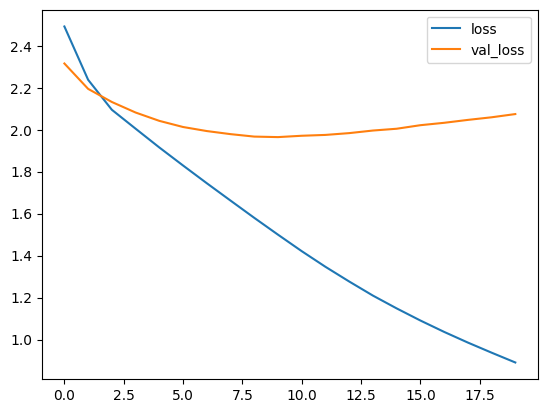

In [25]:
plt.plot(history2.history['loss'],label='loss')
plt.plot(history2.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#

another model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_input_length = 31  # or 30 based on your target
X_train_padded = pad_sequences(X_train, maxlen=max_input_length, padding='post')
X_val_padded = pad_sequences(X_val, maxlen=max_input_length, padding='post')
y_train_padded = pad_sequences(y_train, maxlen=max_input_length, padding='post')
y_val_padded = pad_sequences(y_val, maxlen=max_input_length, padding='post')
model3=tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=eng_vocab_size,output_dim=256,input_length=30),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, kernel_regularizer=tf.keras.regularizers.l2(0.01), return_sequences=True)),
    tf.keras.layers.TimeDistributed(Dense(urd_vocab_size,activation='softmax')) # Added TimeDistributed layer

])
# callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)]
model3.compile(optimizer=Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model3.summary()
history3 = model3.fit(X_train_padded, y_train_padded, epochs=15, batch_size=32, validation_data=(X_val_padded, y_val_padded))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 1783s 4s/step - accuracy: 0.6491 - loss: 6.8651 - val_accuracy: 0.6658 - val_loss: 2.3435
Epoch 2/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 1780s 4s/step - accuracy: 0.6701 - loss: 2.2957 - val_accuracy: 0.6705 - val_loss: 2.2853
Epoch 3/15
388/488 ━━━━━━━━━━━━━━━━━━━━ 5:35 3s/step - accuracy: 0.6768 - loss: 2.1830